In [136]:
#Desabilita logs e mantém apenas logs críticos (para evitar o libcuda ficar me avisando que a GPU tá funcionando)
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [137]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import scipy as spy
import keras
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input
from keras.optimizers import Adam,RMSprop

In [138]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('datasets/winequality-white.csv', sep = ',')
df.head()        

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

Olhando abaixo, não temos nenhum valor N/A, então não precisamos tratar isso.

In [139]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [140]:
print(len(df))


4898


In [141]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

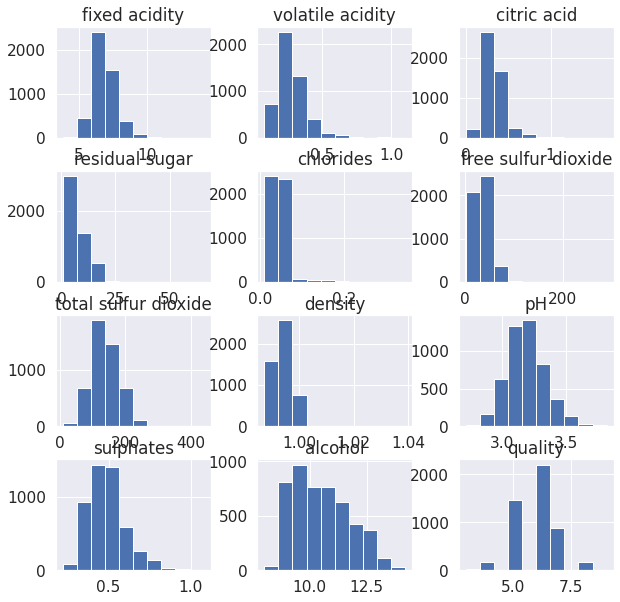

In [142]:
df.hist(figsize = (10, 10))

Matriz de correlação:

<AxesSubplot:>

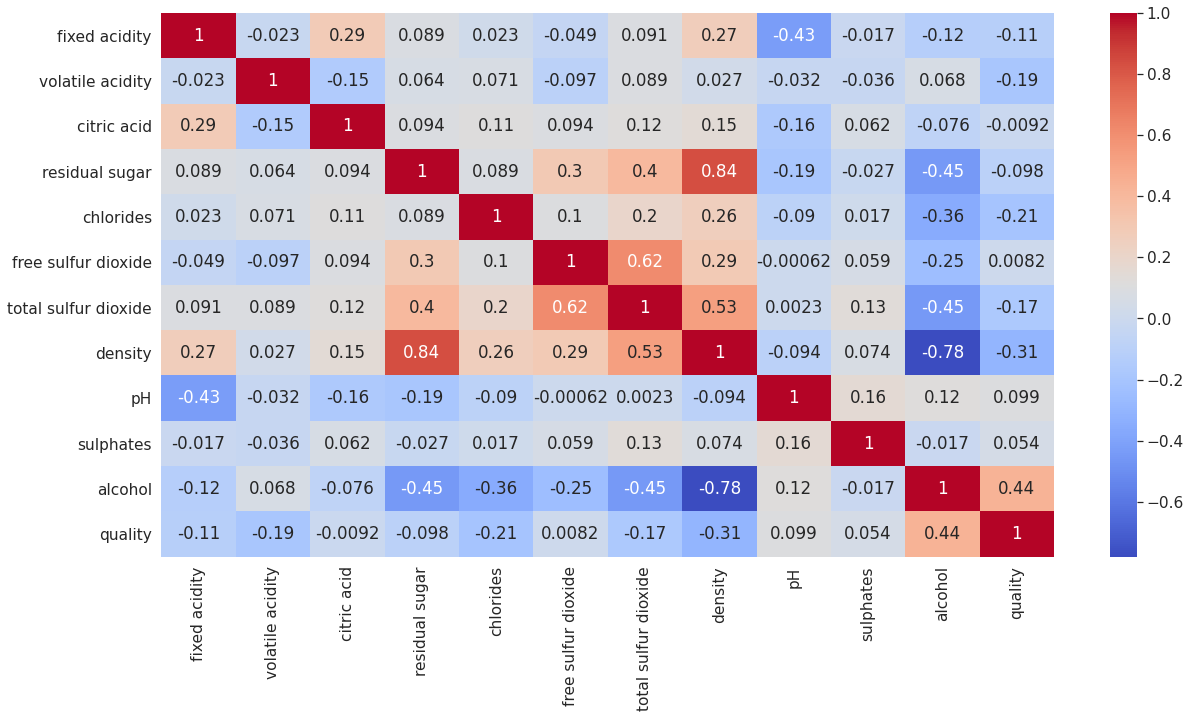

In [143]:
corr=df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(corr,annot=True, cmap='coolwarm')

<h2> SMOTE </h2>

Podemos ver acima que temos um desbalanceamento na quantidade de amostras. Temos muitas regulares e poucas ruins e ótimas. Vamos usar uma técnica chamada SMOTE que consiste em fazer o oversampling das amostras minoritária}s, deixando assim o dataset balanceado. Essa técnica foi descrita no artigo.

In [144]:
X=df.drop(columns=['quality'])
y=df['quality']

In [145]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=4)
X, y = oversample.fit_resample(X, y)

Vemos abaixo que as classificações agora estão igualmente distribuiídas:

In [146]:
print(y.dtypes)
print(y.count())
y.value_counts()

int64
15386


6    2198
5    2198
7    2198
8    2198
4    2198
3    2198
9    2198
Name: quality, dtype: int64

In [147]:
len(X)

15386

In [148]:
len(y)

15386

Pronto, agora temos todas as amostras em quantias iguais.

<h2> Hot encoding </h2>

Ao contrário do outra versão deste notebook, não iremos mudar as classificações para 3 úinicas. Vamos usar todas disponíveis, que são as avaliações de qualidade numa escala de 3 à 9.

No trecho de código abaixo, vou converter as varíaveis categóricas (valores de 3 à 9) em uma tabela. Cada coluna dessa tabela

In [149]:
df = pd.concat([X, y.reindex(X.index)], axis=1)
hot_df = pd.get_dummies(df, columns = ['quality'])
hot_df

fixed acidity  volatile acidity  citric acid  residual sugar  \
0           7.000000          0.270000     0.360000       20.700000   
1           6.300000          0.300000     0.340000        1.600000   
2           8.100000          0.280000     0.400000        6.900000   
3           7.200000          0.230000     0.320000        8.500000   
4           7.200000          0.230000     0.320000        8.500000   
...              ...               ...          ...             ...   
15381       6.975289          0.322355     0.396467        3.447107   
15382       7.550014          0.325800     0.350801        5.020049   
15383       6.699743          0.340051     0.329897        1.719692   
15384       7.955091          0.311217     0.376726        6.478328   
15385       7.707199          0.326978     0.380360        6.548216   

       chlorides  free sulfur dioxide  total sulfur dioxide   density  \
0       0.045000            45.000000            170.000000  1.001000   
1       0.049000            14.000000            132.000000  0.994000   
2       0.050000            30.000000             97.000000  0.995100   
3       0.058000            47.000000            186.000000  0.995600   
4       0.058000            47.000000            186.000000  0.995600   
...          ...                  ...                   ...       ...   
15381   0.023270            47.212389            116.741321  0.989988   
15382   0.026320            25.520022             99.820214  0.992443   
15383   0.023194            25.396405             90.585620  0.989780   
15384   0.028589            26.168146            106.139422  0.993634   
15385   0.024237            46.359648            120.834544  0.992442   

             pH  sulphates    alcohol  quality_3  quality_4  quality_5  \
0      3.000000   0.450000   8.800000          0          0          0   
1      3.300000   0.490000   9.500000          0          0          0   
2      3.260000   0.440000  10.100000          0          0          0   
3      3.190000   0.400000   9.900000          0          0          0   
4      3.190000   0.400000   9.900000          0          0          0   
...         ...        ...        ...        ...        ...        ...   
15381  3.313880   0.382587  12.775289          0          0          0   
15382  3.330199   0.552999  11.639989          0          0          0   
15383  3.402021   0.572098  12.499743          0          0          0   
15384  3.296172   0.528695  11.315927          0          0          0   
15385  3.250647   0.396691  11.856110          0          0          0   

       quality_6  quality_7  quality_8  quality_9  
0              1          0          0          0  
1              1          0          0          0  
2              1          0          0          0  
3              1          0          0          0  
4              1          0          0          0  
...          ...        ...        ...        ...  
15381          0          0          0          1  
15382          0          0          0          1  
15383          0          0          0          1  
15384          0          0          0          1  
15385          0          0          0          1  

[15386 rows x 18 columns]

In [150]:
y = hot_df[['quality_3','quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8', 'quality_9']]
y

quality_3  quality_4  quality_5  quality_6  quality_7  quality_8  \
0              0          0          0          1          0          0   
1              0          0          0          1          0          0   
2              0          0          0          1          0          0   
3              0          0          0          1          0          0   
4              0          0          0          1          0          0   
...          ...        ...        ...        ...        ...        ...   
15381          0          0          0          0          0          0   
15382          0          0          0          0          0          0   
15383          0          0          0          0          0          0   
15384          0          0          0          0          0          0   
15385          0          0          0          0          0          0   

       quality_9  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
15381          1  
15382          1  
15383          1  
15384          1  
15385          1  

[15386 rows x 7 columns]

<h1>Separando o dataset de treinamento e o de predição</h1>

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=21)
print('Formato do dataset de treinamento Xs:{}'.format(X_train.shape))
print('Formato do datasett de teste Xs:{}'.format(X_test.shape))
print('Formato do dataset de treino y:{}'.format(y_train.shape))
print('Formato do dataset de test y:{}'.format(y_test.shape))

Formato do dataset de treinamento Xs:(12308, 11)
Formato do datasett de teste Xs:(3078, 11)
Formato do dataset de treino y:(12308, 7)
Formato do dataset de test y:(3078, 7)


<h1> Construção do modelo </h1>

O artigo utilizou relu e tanh. Aqui abaixo vamos usar relu.

In [152]:
dimension = X_train.shape[1]
from keras import backend as K
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim = dimension,  activation='relu'))
    model.add(Dense(60, input_dim = dimension,  activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                660       
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 427       
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50, batch_size=10)

Epoch 1/50
1231/1231 [==============================] - 1s 566us/step - loss: 1.8933 - accuracy: 0.3080 - val_loss: 1.5643 - val_accuracy: 0.3499
Epoch 2/50
1231/1231 [==============================] - 1s 594us/step - loss: 1.5331 - accuracy: 0.3779 - val_loss: 1.5065 - val_accuracy: 0.3866
Epoch 3/50
1231/1231 [==============================] - 1s 557us/step - loss: 1.4444 - accuracy: 0.4123 - val_loss: 1.4179 - val_accuracy: 0.4110
Epoch 4/50
1231/1231 [==============================] - 1s 548us/step - loss: 1.3990 - accuracy: 0.4345 - val_loss: 1.3639 - val_accuracy: 0.4428
Epoch 5/50
1231/1231 [==============================] - 1s 594us/step - loss: 1.3573 - accuracy: 0.4487 - val_loss: 1.3934 - val_accuracy: 0.4477
Epoch 6/50
1231/1231 [==============================] - 1s 550us/step - loss: 1.3255 - accuracy: 0.4647 - val_loss: 1.3441 - val_accuracy: 0.4519
Epoch 7/50
1231/1231 [==============================] - 1s 575us/step - loss: 1.2937 - accuracy: 0.4816 - val_loss: 1.3126 -

Sobre val_accuracy e accuracy:

Quando ambos crescem na mesma proporção quer dizer que o modelo não causou nem overfitting nem underfitting. 

Se o accuracy cresce mais que o val_accuracy, quer dizer que temos overfitting. 

Se o accuracy cresce menos que o val_accuracy, quer dizer que temos underfitting. 

<h2>avaliação do resultado: </h2>

In [ ]:
y_pred = model.predict(X_test)
def max_probs(array):
    parsed_pred = np.empty((0,7))
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = np.zeros((7,))
        x[idx_max] = 1
        array[idx] = x

max_probs(y_pred)
y_pred

In [ ]:
def to_category(array):
    categories = []
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = 0
        if idx_max == 0: x = 3
        if idx_max == 1: x = 4
        if idx_max == 2: x = 5
        if idx_max == 3: x = 6
        if idx_max == 4: x = 7
        if idx_max == 5: x = 8
        if idx_max == 6: x = 9
        categories.append(x)
    return categories


categorical_y_pred = to_category(y_pred)
categorical_y_test = to_category(y_test.to_numpy())
data = confusion_matrix(categorical_y_test, categorical_y_pred)

In [ ]:
len(categorical_y_test)

Matriz de confusão:

In [ ]:
df_cm = pd.DataFrame(data, columns=np.unique(categorical_y_test), index = np.unique(categorical_y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sb.set(font_scale=1.4)#for label size
sb.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Verificação de acurácia geral

In [ ]:
correct = 0
total = 0
for i in range(len(categorical_y_test)):
    if(categorical_y_test[i] == categorical_y_pred[i]):
        correct += 1
    total += 1
accuracy = (correct/total)

In [ ]:
accuracy

<h1>Conclusão </h1>



Usando Smote porém sem separar as categorias em 3 categorias de qualidade antes de fazer o treinamento, temos uma queda de 10% na capacidade de classificação. Isso era esperado, é mais fácil predizer o vinho quando não é mais necessária tanta exatidão no momento de prever a categoria.